In [1]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import import_ipynb
from scipy.interpolate import PchipInterpolator
import seaborn as sns

In [2]:
def interpolador(subject, method, size):
    # data = np.array([int(line.strip()) for line in subject.to_numpy()])  # Si lo obtienes de un DataFrame
    data = subject
    x = np.arange(len(data))
    
    # Crear 'size' puntos equidistantes
    x_new = np.linspace(0, len(data) - 1, size*(len(data)-1) + len(data))
    
    if method == 'lineal':
        data_interp = np.interp(x_new, x, data)
    elif method == 'herm':
        interpolator = PchipInterpolator(x, data)
        data_interp = interpolator(x_new)
    
    return x_new, data_interp

In [3]:
def discretizar(array, num_partitions):
    if num_partitions == 1:
        print(" Minimo de particiones: 2")
        return np.array([])
    window = (np.abs(np.min(array)) + np.abs(np.max(array)))/(num_partitions - 1)
    discretizador = [np.min(array)+window*(i) for i in range(num_partitions)]
    if discretizador[len(discretizador)-1] != np.max(array):
        discretizador[len(discretizador)-1] = np.max(array)
    array_discreto = []
    for i,valor in enumerate(array):
        array_discreto.append(min(discretizador, key=lambda x: abs(x - valor)))

    return array_discreto

def discretizar_x(array_y, num_partitions):
    if num_partitions == 1:
        print(" Minimo de particiones: 2")
        return np.array([])
    array_x = range(int(len(array_y)))
    window = (len(array_x))/(num_partitions - 1)
    x_discreto = [int(window*(i)) for i in range(num_partitions)]
    array_discreto = []
    for i in x_discreto[0:len(x_discreto)-1]:
        array_discreto.append(array_y[i])
    array_discreto.append(array_y[len(array_x)-1])

    return x_discreto, array_discreto

In [4]:
def J_bivariante(X,Y,tau,fases):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    ff1 = np.angle(np.fft.rfft(X))[:fases]
    ff2 = np.angle(np.fft.rfft(Y))[:fases]
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2=cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos=[]
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        v1_norm=v1/np.linalg.norm(v1)
        v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)
    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J

In [5]:
def J_univariante1(X,tau,fases):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    x1 = X[tau:]
    y1 = X[:-tau]
    ff1 = np.angle(np.fft.rfft(x1))[:fases]
    ff2 = np.angle(np.fft.rfft(y1))[:fases]
    
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2 = cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos = []
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        if np.linalg.norm(v1) == 0:
            v1_norm=v1
        else:
            v1_norm=v1/np.linalg.norm(v1)
        if np.linalg.norm(v2) == 0:
            v2_norm=v2
        else:
            v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)
    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def arm_detector(data, num_ventanas=25, b=0.6):
    n = len(data)
    x = np.arange(n)
    
    # Calcular el tamaño de cada ventana
    window_size = n // num_ventanas

    # Lista para almacenar los porcentajes de puntos dentro de las regiones
    porcentajes = []

    # Ajustar y graficar el ajuste lineal por cada ventana con las líneas paralelas
    for i in range(0, n, window_size):
        end = i + window_size
        if end > n:
            end = n
        
        x_window = x[i:end].reshape(-1, 1)
        y_window = data[i:end]
        
        # Crear y ajustar el modelo de regresión lineal
        modelo = LinearRegression()
        modelo.fit(x_window, y_window)
        
        # Obtener la pendiente y la intersección de la recta ajustada
        pendiente = modelo.coef_[0]
        interseccion = modelo.intercept_
        
        # Predecir valores ajustados
        y_pred = modelo.predict(x_window)
                
        # Calcular las rectas paralelas desplazadas por 'b'
        y_paralela_superior = pendiente * x_window + (interseccion + b)
        y_paralela_inferior = pendiente * x_window + (interseccion - b)
                
        # Calcular el porcentaje de datos dentro de la región delimitada por las líneas paralelas
        dentro_region = np.sum((y_window >= y_paralela_inferior.flatten()) & (y_window <= y_paralela_superior.flatten()))
        fuera_region = len(y_window) - dentro_region
        
        # Calcular el porcentaje de datos dentro de la región respecto a los datos fuera de la región
        porcentaje = (dentro_region * 100)/(dentro_region + fuera_region)
        porcentajes.append(porcentaje)

    def indice_mayor_90(arr):
        n = len(arr)
    
        # Revisar cada índice para encontrar el primero que cumpla la condición
        for i in range(n):
            if np.all(arr[i:] > 80) and len(arr[i:]) > 4:
                return i
        # Si no hay tal índice, regresar el último índice
        return n - 1
    
    indice = indice_mayor_90(np.array(porcentajes))*window_size
    return indice

def J_univariante(X,tau, corte):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    x1 = X[tau:]
    y1 = X[:-tau]
    ff1 = np.angle(np.fft.rfft(x1))
    ff2 = np.angle(np.fft.rfft(y1))
    if corte:
        # print(len(ff1),len(ff2))
        transition_point1 = arm_detector(ff1)
        transition_point2 = arm_detector(ff2)
        if transition_point1 != transition_point2:
            transition_point1 = transition_point2 = min(transition_point1, transition_point2)
        ff2 = ff2[:transition_point2]
        ff1 = ff1[:transition_point1]
        # print(len(ff1),len(ff2))
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2 = cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos = []
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        if np.linalg.norm(v1) == 0:
            v1_norm = v1
        else:
             v1_norm=v1/np.linalg.norm(v1)
        if np.linalg.norm(v2) == 0:
            v2_norm = v2
        else:
            v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)

    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J, angulos

1000
1000
(0.642480648467095, [0.08272002476408824, 3.007440402530562, 3.120324560721802, 3.1200969562972456, 3.134594105885264, 3.133804018699851, 6.2384876670724, 3.144404285988526, 3.1441375144553976, 3.1430624377862206, 3.1433167103373356, 3.141795395727168, 3.1447173838529316, 3.14081255315286, 3.1411203354823027, 3.149115682871455, 3.136221427120382, 3.140998712574987, 3.1459225138285403, 3.134415921318948, 3.1484265156506757, 3.139727863552915, 3.147799518071186, 3.1379772240732398, 3.1463169080756677, 3.1221894127111707, 3.170241914673782, 3.0967334979159458, 3.1919161129080327, 3.1414273271005446, 3.1009767161460347, 3.188930468146784, 3.1137095581740164, 3.1490280385066054, 3.1152960320426595, 3.160102546453825, 3.146256203290854, 3.159975984639581, 3.1274867479623993, 3.153745756679985, 3.0800443603559398, 3.2288598715227694, 3.072599791111592, 3.173681795686548, 3.1100016948751317, 3.1484351093285956, 3.141256999876223, 3.162847125297548, 3.1996049553853867, 2.9902393377104

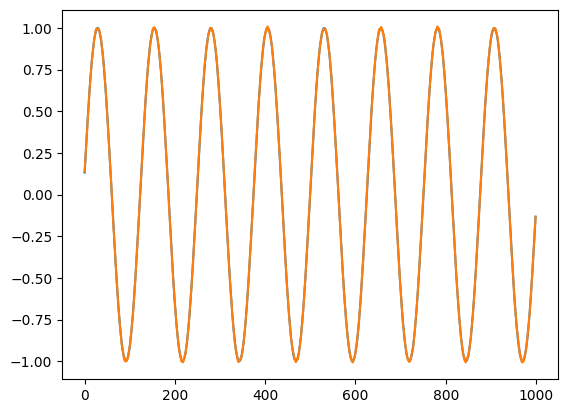

In [7]:
def generar_uniforme_centrada(n, varianza):
    # Calcular el límite superior e inferior de la distribución uniforme
    limite = np.sqrt(varianza) # varianza*3
    # Generar n números aleatorios con distribución uniforme entre -limite y limite
    return np.random.uniform(-limite, limite, n)
afa = [np.sin(x) for x in np.linspace(-25,25,1000)]
plt.plot(afa)
ri = afa + generar_uniforme_centrada(len(afa),0.0001)
print(len(ri))
print(len(afa))
plt.plot(ri)
print(J_univariante(ri, 1, len(ri)))

ruido = generar_uniforme_centrada(1, 0.00001)
print(ruido[0])

In [8]:


def lyapunov_exponent_from_orbit(orbit, r):
    lyapunov_sum = 0

    for x in orbit:
        # Derivada de la función logística
        derivative = abs(r * (1 - 2 * x))
        if derivative == 0:
            lyapunov_sum += 0
        else:
            lyapunov_sum += np.log(derivative)

    # Calcular el exponente de Lyapunov
    lyapunov_exponent = lyapunov_sum / len(orbit)
    return lyapunov_exponent


In [9]:
def brownian_bridge(t0, tT, x0, xT, n_steps):
    t = np.linspace(t0, tT, n_steps)
    #Generar movimiento browniano con media cero
    W = np.random.normal(0, np.sqrt(t[1] - t[0]), size=n_steps-1)
    W = np.insert(np.cumsum(W), 0, 0)  # Inserta W(0) = 0 y suma acumulativa
    # Interpolación del Brownian Bridge
    X = x0 + (t - t0) / (tT - t0) * (xT - x0) + W - (t - t0) / (tT - t0) * W[-1]
    return t, X

def interpolador_estocastico(s_0_discreto, n_steps):
    t_list, X_list = [], []
    for i in range(len(s_0_discreto)- 1):
        t0 = i
        tT = i+1
        x0 = s_0_discreto[i]
        xT = s_0_discreto[i+1]
        t, X = brownian_bridge(t0, tT, x0, xT, n_steps)
        t_list = np.concatenate((t_list, t))
        X_list = np.concatenate((X_list, X))
    return X_list

In [10]:
def graficar_angulos_en_circulo(angulos):
    # Crear una figura y un set de ejes
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    
    # Dibujar el círculo unitario
    circulo = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--')
    ax.add_artist(circulo)

    # Coordenadas del círculo unitario
    x_circulo = np.cos(np.linspace(0, 2 * np.pi, 100))
    y_circulo = np.sin(np.linspace(0, 2 * np.pi, 100))
    ax.plot(x_circulo, y_circulo, 'b--')  # Línea del círculo

    # Graficar los puntos correspondientes a los ángulos en el círculo unitario
    for angulo in angulos:
        x = np.cos(angulo)
        y = np.sin(angulo)
        ax.plot([0, x], [0, y], color='gray', linestyle='--')  # Línea desde el origen
        ax.plot(x, y, 'ro')  # Punto en el círculo

    # Ajustes del gráfico
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_title('Ángulos en el círculo unitario')
    
    # Dibujar los ejes
    ax.axhline(0, color='black',linewidth=0.5)
    ax.axvline(0, color='black',linewidth=0.5)

    # Mantener proporciones iguales
    ax.set_aspect('equal')
    plt.grid(True)
    plt.show()


Dinámica simbólica
3.0033444816053514


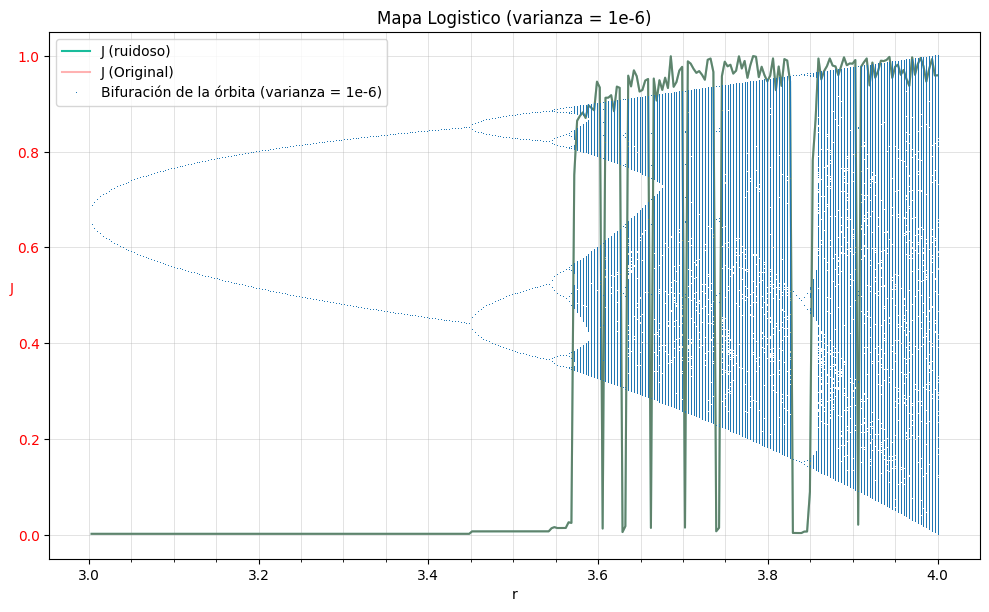

Correlación de Spearman: 0.9999999999999998


In [265]:
"""interpolacion despues de dinamica simbolica"""


def logistic_map(r, x):
    return r * x * (1 - x)

def plot_orbit_diagram(num_partitions,discreto,interpolacion, size,graficar, r_min = 3.0, r_max = 4.0, num_points_per_r=300,
 num_iterations_discard=3000, num_iterations_display=2000):
    if discreto == "no" and interpolacion == "si": 
        print("Haz seleccionado interpolación a los datos continuos, eso no tiene caso")
        return 1,2

    if interpolacion == "si":
        print("Interpolación")

    r_values = []
    orbit_values = []
    
    for r in np.linspace(r_min, r_max, num_points_per_r):
        if r == 3.0:
            continue
        x = 0.6
        for _ in range(num_iterations_discard): # Converger
            # x = np.clip(x, 0.0, 1.0)
            x = logistic_map(r, x) #+ generar_uniforme_centrada(1, 1e-6)[0]
        for _ in range(num_iterations_display):
            # x = np.clip(x, 0.0, 1.0)
            x = logistic_map(r, x) #+ generar_uniforme_centrada(1, 1e-6)[0]
            r_values.append(r)
            orbit_values.append(x)
        
    #A partir de aqui, orbita continua de logistica completada
    if discreto == "si":
        print('Dinámica simbólica')
        # orbit_values = discretizar(orbit_values, num_partitions )
        
    a = 0
    J_values=[]
    J_index=[]
    lyapunov_values = []
    
    r_values_interp = []
    orbit_values_interp = np.array([])
    ti, to = True, True
    for i in range(0, len(r_values) - 1):
        if r_values[i] != r_values[i+1]:
            r_single_orbit = orbit_values[a:i+1]
            a = i+1
            
            if interpolacion == 'si':
                x = np.arange(len(r_single_orbit))
                x_new, data_interp = interpolador(r_single_orbit, 'lineal', 15)
                # data_interp = interpolador_estocastico(data_interp, 3)
                # data_interp = r_single_orbit
                # data_interp = data_interp + generar_uniforme_centrada(len(data_interp),1e-6)
                r_values_interp = r_values_interp + [r_values[i]]*len(data_interp)
                orbit_values_interp = np.concatenate((orbit_values_interp, data_interp))

                r_single_orbit = data_interp

            lyapunov = lyapunov_exponent_from_orbit(r_single_orbit, r_values[i])
            lyapunov_values.append(lyapunov)
            J, angulos = J_univariante(r_single_orbit, 1, False)
            if r_values[i] > 3.0 and ti == True:
                print(r_values[i])
            #     plt.plot(r_single_orbit,'.')
            #     print("r=",r_values[i])
                ti = False
            #     plt.show()
            #     print(detect_var(r_single_orbit))
                # to = False
            J_values.append(J)
            J_index.append(r_values[i])
    
    #ultimo valor de r
    lyapunov = lyapunov_exponent_from_orbit(orbit_values[a:], r_values[len(r_values) - 1])  
    lyapunov_values.append(lyapunov)
    r_single_orbit = orbit_values[a:]
    if interpolacion == 'si':
        x = np.arange(len(orbit_values[a:]))
        x_new, data_interp = interpolador(orbit_values[a:], 'lineal', 15)
        # data_interp = interpolador_estocastico(data_interp, 3)
        # data_interp = orbit_values[a:]
        # data_interp = data_interp + generar_uniforme_centrada(len(data_interp), 1e-6)
        r_values_interp = r_values_interp + [r_values[i]]*len(data_interp)
        orbit_values_interp = np.concatenate((orbit_values_interp, data_interp))
        r_single_orbit = data_interp
    
    J = J_univariante(r_single_orbit, 1, False)[0]
    J_values.append(J)
    J_index.append(r_values[len(r_values) - 1])
    #A partir de aqui, lyapunob y J fueron calculados
    
    J_continuo = np.load('logistic_map/j_logistic_continuo.npy')

    if graficar == True:
        fig, ax1 = plt.subplots(figsize=(10,6))
        
        if discreto == "no":
            color = "red"
        elif discreto == "si":
            color = '#1ABC9C'
    
        ax1.plot(J_index, J_values, color=color, label='J (ruidoso)' , alpha = 1)
        if discreto == "si":
            ax1.plot(J_index, J_continuo, 'red',label='J (Original)', alpha = 0.3)
            if interpolacion == "si":
                ax1.plot(r_values_interp, orbit_values_interp, ',', label=f'Bifuración de la órbita (+ interpolación de 15 pts)', alpha=0.5)
            else: 
                ax1.plot(r_values, orbit_values, ',', label='Bifuración de la órbita (varianza = 1e-6)', alpha=1)
        if discreto == "no":
            ax1.plot(r_values, orbit_values, ',', label='Bifurcación de la órbita', alpha=1)
        ax1.set_xlabel('r')
        ax1.set_ylabel('J', color='r', rotation = 360)
        ax1.tick_params(axis='y', labelcolor='r')
        # ax1.set_ylim(0,1)
        ax1.legend(loc = 'upper left')
        
        major_ticks_x = np.linspace(3, 4, 6)  # 0.0, 0.2, ..., 1.0
        minor_ticks_x = np.linspace(3, 4, 21)  # Ticks secundarios

        major_ticks_y = np.linspace(0, 1, 6)  # -1, -0.5, 0, 0.5, 1.0
        minor_ticks_y = np.linspace(0, 1, 6)  # Ticks secundarios

        # Configurar los ticks del eje X
        plt.xticks(major_ticks_x)  # Solo etiquetar los ticks principales
        plt.gca().set_xticks(minor_ticks_x, minor=True)  # Agregar ticks menores sin etiquetas

        # Configurar los ticks del eje Y
        plt.yticks(major_ticks_y)  # Solo etiquetar los ticks principales
        plt.gca().set_yticks(minor_ticks_y, minor=True)  # Agregar ticks menores sin etiquetas

        # Activar la cuadrícula
        plt.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.5)  # Para ticks principales
        plt.grid(which='minor', linestyle='-', linewidth=0.5, alpha=0.5)         

        if discreto == "no":
            ax2 = ax1.twinx()
            ax2.axhline(y=0, color='black', linestyle='--', alpha =0.55)
            ax2.plot(J_index, lyapunov_values, 'black', label = 'λ')
            ax2.set_ylabel('λ', color='black', rotation = 360)
            ax2.tick_params(axis='y', labelcolor='black')
            ax2.legend(loc='center right',framealpha=0.5)
        
        fig.tight_layout()  
        # plt.title(f'Logistic Map (Discret ={discreto}, interp= {interpolacion})')
        # plt.title(f'Mapa Logístico con discretización en el eje y ({num_partitions} Particiones)')
        plt.title(f'Mapa Logistico (varianza = 1e-6)')
        plt.show()

    if interpolacion == 'no':
        return J_index, J_values, r_values, orbit_values, lyapunov_values
    else:
        return J_index, J_values, r_values_interp, orbit_values_interp, lyapunov_values 


# with open('logistic_map/lyapunov_continuo.txt', 'r') as f:
#         lyapunov_continuo = [float(line.strip()) for line in f]

J_continuo = np.load('logistic_map/j_logistic_continuo.npy')

J_index, J_values, r_values, orbit_values, lyapunov_values = plot_orbit_diagram(15,"si","no", 20 ,True)
# J_index, J_values, r_values, orbit_values, lyapunov_values_continuo = plot_orbit_diagram(50,"no", "no", 20 ,True)


# Calcular correlación de Spearman
correlacion, p_valor = spearmanr(J_values, J_continuo)

print(f'Correlación de Spearman: {correlacion}')

# np.save('J_continuo_2_5.npy', np.array(J_values))

In [11]:
# Cargar la lista desde un archivo .txt
periodos_logistic = []
with open("logistic_map\periodos_logistic.txt", "r") as file:
    for line in file:
        # Convertir cada línea a su tipo adecuado (número o cadena)
        line = line.strip()  # Eliminar saltos de línea o espacios extra
        if line.replace(".", "", 1).isdigit():  # Verifica si es un número (enteros o flotantes)
            if "." in line:
                periodos_logistic.append(float(line))  # Si tiene punto, es flotante
            else:
                periodos_logistic.append(int(line))  # Si no, es entero
        else:
            periodos_logistic.append(line)  # Si no es número, es una cadena

# Ver la lista cargada
print(periodos_logistic)


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 16, 16, 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 10, 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 6, 12, 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 8, 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 14, 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 5, 10, 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos'

Interpolación
Dinámica simbólica


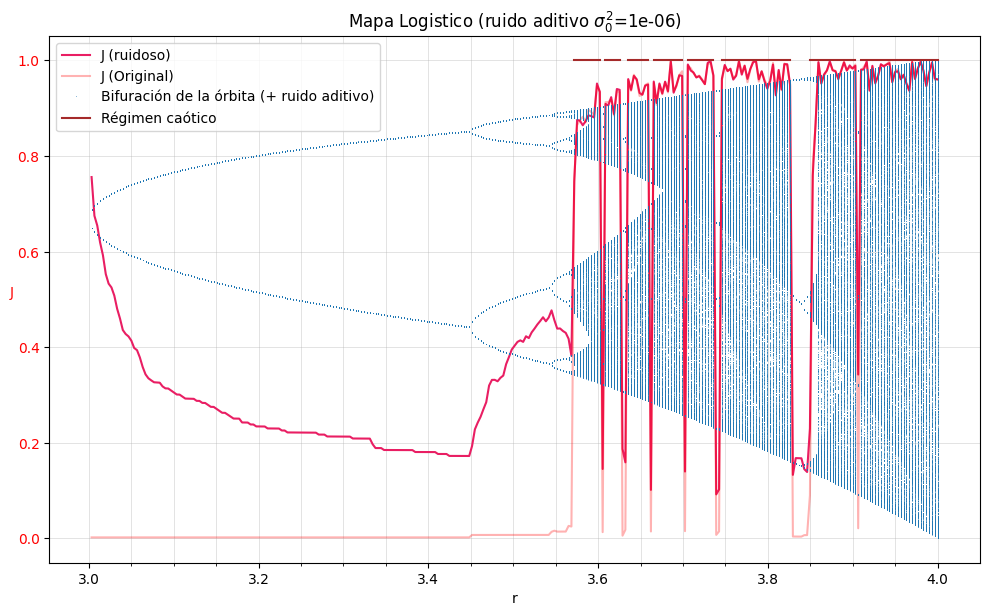

Correlación de Spearman: 0.8170618973921634


In [1227]:
"""interpolacion despues de dinamica simbolica"""
"""CON VARIANZA FUNCIONAL"""

def logistic_map(r, x):
    return r * x * (1 - x)

def plot_orbit_diagram(ruido,num_partitions,discreto,interpolacion, size,graficar, r_min = 3.0, r_max = 4.0, num_points_per_r=300,
 num_iterations_discard=3000, num_iterations_display=2000):
    if discreto == "no" and interpolacion == "si": 
        print("Haz seleccionado interpolación a los datos continuos, eso no tiene caso")
        return 1,2

    if interpolacion == "si":
        print("Interpolación")
    
    r_values = []
    orbit_values = []
    
    for r in np.linspace(r_min, r_max, num_points_per_r):
        if r == 3.0:
            continue
        x = 0.6
        ruidos = [1e-10,1e-8,1e-7,1e-4,1e-5,1e-6]
        colores = ['gray','#2ECC71','purple','#E91E63','#1ABC9C', '#FFD700']

        for _ in range(num_iterations_discard): # Converger
            # x = np.clip(x, 0.0, 1.0)
            x = logistic_map(r, x) #+ generar_uniforme_centrada(1, ruido)[0]
        for _ in range(num_iterations_display):
            # x = np.clip(x, 0.0, 1.0)
            x = logistic_map(r, x) #+ generar_uniforme_centrada(1, ruido)[0]
            r_values.append(r)
            orbit_values.append(x)
        
    #A partir de aqui, orbita continua de logistica completada
    if discreto == "si":
        print('Dinámica simbólica')
        # orbit_values = discretizar(orbit_values, num_partitions )
        
    a = 0
    b = 0
    J_values=[]
    J_index=[]
    caotico = []
    varianzas=[]
    lyapunov_values = []
    
    r_values_interp = []
    orbit_values_interp = np.array([])
    random_array = generar_uniforme_centrada(num_iterations_display,ruido)
    ti, to = True, True
    for i in range(0, len(r_values) - 1):
        if r_values[i] != r_values[i+1]:
            r_single_orbit = orbit_values[a:i+1]
            a = i+1
            if interpolacion == 'si':
                x = np.arange(len(r_single_orbit))
                # x_new, data_interp = interpolador(r_single_orbit, 'lineal', 15)
                # data_interp = interpolador_estocastico(data_interp, 3)
                data_interp = r_single_orbit
                data_interp = data_interp + random_array
                r_values_interp = r_values_interp + [r_values[i]]*len(data_interp)
                orbit_values_interp = np.concatenate((orbit_values_interp, data_interp))

                r_single_orbit = data_interp
            var = var_per_state(r_single_orbit, periodos_logistic[b])
            if var == "Caos":
                varianzas.append(np.nan)
                caotico.append(1.0)
            else:
                caotico.append(np.nan)
                varianzas.append( np.sum(np.array(var))/periodos_logistic[b])
            lyapunov = lyapunov_exponent_from_orbit(r_single_orbit, r_values[i])
            lyapunov_values.append(lyapunov)
            J, angulos = J_univariante(r_single_orbit, 1, False)
            # if r_values[i] > 3.5 and ti == True:
            #     plt.plot(r_single_orbit,'.')
            #     plt.show()
            #     print(r_single_orbit)
            #     ti = False
            #     plt.show()
            #     print(detect_var(r_single_orbit))
            # if J > 0.1 and to == True and r_values[i] > 3.8:
                # plt.plot(np.angle(np.fft.rfft(r_single_orbit)), ',')
                # plt.show()
            #     print(r_values[i])
            #     plt.plot(r_single_orbit, ',')
            #     plt.show()
            #     graficar_angulos_en_circulo(angulos)
            #     plt.show()
                # to = False
            J_values.append(J)
            J_index.append(r_values[i])
            b += 1
    
    #ultimo valor de r
    lyapunov = lyapunov_exponent_from_orbit(orbit_values[a:], r_values[len(r_values) - 1])  
    lyapunov_values.append(lyapunov)
    r_single_orbit = orbit_values[a:]
    if interpolacion == 'si':
        x = np.arange(len(orbit_values[a:]))
        # x_new, data_interp = interpolador(orbit_values[a:], 'lineal', 15)
        # data_interp = interpolador_estocastico(data_interp, 3)
        data_interp = orbit_values[a:]
        data_interp = data_interp + random_array
        r_values_interp = r_values_interp + [r_values[i]]*len(data_interp)
        orbit_values_interp = np.concatenate((orbit_values_interp, data_interp))
        r_single_orbit = data_interp
    
    J = J_univariante(r_single_orbit, 1, False)[0]
    J_values.append(J)
    varianzas.append(np.nan)
    caotico.append(1.0)
    J_index.append(r_values[len(r_values) - 1])
    #A partir de aqui, lyapunob y J fueron calculados

    J_continuo = np.load('logistic_map/j_logistic_continuo.npy')

    if graficar == True:
        fig, ax1 = plt.subplots(figsize=(10,6))
        
        if discreto == "no":
            color = "red"
        elif discreto == "si":
            color = '#E91E63'
    
        ax1.plot(J_index, J_values, color=color, label='J (ruidoso)' , alpha = 1)
        if discreto == "si":
            ax1.plot(J_index, J_continuo, 'red',label='J (Original)', alpha = 0.3)
            if interpolacion == "si":
                ax1.plot(r_values_interp, orbit_values_interp, ',', label=f'Bifuración de la órbita (+ ruido aditivo)', alpha=0.5)
            else: 
                ax1.plot(r_values, orbit_values, ',', label=f'Bifuración de la órbita (+ruido iterado)', alpha=1)
        if discreto == "no":
            ax1.plot(r_values, orbit_values, ',', label='Bifurcación de la órbita', alpha=1)
        ax1.set_xlabel('r')
        ax1.set_ylabel('J', color='r', rotation = 360)
        ax1.tick_params(axis='y', labelcolor='r')
        # ax1.set_ylim(0,1)
        ax1.plot(J_index, np.array(caotico), color ='brown',linestyle='-', label = 'Régimen caótico')
        ax1.legend(loc = 'upper left')
        major_ticks_x = np.linspace(3, 4, 6)  # 0.0, 0.2, ..., 1.0
        minor_ticks_x = np.linspace(3, 4, 21)  # Ticks secundarios

        major_ticks_y = np.linspace(0, 1, 6)  # -1, -0.5, 0, 0.5, 1.0
        minor_ticks_y = np.linspace(0, 1, 6)  # Ticks secundarios

        # Configurar los ticks del eje X en ax1
        ax1.set_xticks(major_ticks_x)  # Solo etiquetar los ticks principales
        ax1.set_xticks(minor_ticks_x, minor=True)  # Agregar ticks menores sin etiquetas

        # Configurar los ticks del eje Y en ax1
        ax1.set_yticks(major_ticks_y)  # Solo etiquetar los ticks principales
        ax1.set_yticks(minor_ticks_y, minor=True)  # Agregar ticks menores sin etiquetas

        # Activar la cuadrícula en ax1
        ax1.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.5)  # Para ticks principales
        ax1.grid(which='minor', linestyle='-', linewidth=0.5, alpha=0.5)  # Para ticks menores      

        if discreto == "no":
            ax2 = ax1.twinx()
            ax2.axhline(y=0, color='black', linestyle='--', alpha =0.55)
            ax2.plot(J_index, lyapunov_values, 'black', label = 'λ')
            ax2.set_ylabel('λ', color='black', rotation = 360)
            ax2.tick_params(axis='y', labelcolor='black')
            ax2.legend(loc='center right',framealpha=0.5)

        if discreto == "si" and interpolacion == "no":
            ax2 = ax1.twinx() #[round(var*3, 8) if not np.isnan(var) else np.nan for var in varianzas]
            ax2.plot(J_index, varianzas, color ='black',ls='-',lw=0.4,marker='.',mew=0.1, label = r'$\sigma^2$')
            ax2.set_ylabel(r'$\sigma^2$', color='black', rotation = 360)
            # ax2.set_ylabel('P', color='black', rotation = 360)
            ax2.tick_params(axis='y', labelcolor='black')
            ax2.legend(loc='center right',framealpha=0.5)
            ######################
            # ax2.set_yscale('log')
            # if 1.5*max(varianzas) > 0.1:
                # ax2.set_ylim(0.8e-10, 1.5*max(varianzas))
            # else:
                # ax2.set_ylim(0.8e-10, 0.1)
            # ax2.set_xlim(3.7,3.8)
            # ax2.set_ylim(0,np.max(varianzas[:170]))
            #####################

        fig.tight_layout()  
        # plt.title(f'Logistic Map (Discret ={discreto}, interp= {interpolacion})')
        # plt.title(f'Mapa Logístico con discretización en el eje y ({num_partitions} Particiones)')
        plt.title(r'Mapa Logistico (ruido aditivo $\sigma_0^2$='+f'{ruido})')
        # plt.title('Mapa Logístico')
        # fig.savefig("logistic_map\logistic_ruido_iterado\logistic_"+str(ruido)+".png")
        plt.show()

    # np.save("varianzas_OG.npy", np.array(varianzas, dtype=object))
    if interpolacion == 'no':
        return J_index, J_values, r_values, orbit_values, lyapunov_values
    else:
        return J_index, J_values, r_values_interp, orbit_values_interp, lyapunov_values 


J_continuo = np.load('logistic_map/j_logistic_continuo.npy')

ruido = 1e-6
J_index, J_values, r_values, orbit_values, lyapunov_values = plot_orbit_diagram(ruido,15,"si","si", 20 ,True)
# J_index, J_values, r_values, orbit_values, lyapunov_values_continuo = plot_orbit_diagram(50,"no", "no", 20 ,True)


# Calcular correlación de Spearman
correlacion, p_valor = spearmanr(J_values, J_continuo)

print(f'Correlación de Spearman: {correlacion}')

In [12]:
def detect_per(Xn, tolerancia=1e-6, max_periodo=100):
    """
    Detecta si Xn está en un régimen periódico y calcula la varianza por punto fijo.
    Si el sistema es caótico, devuelve una lista con una varianza igual a 1.
    
    Parámetros:
        Xn (array): Secuencia del mapa logístico.
        tolerancia (float): Tolerancia para determinar igualdad de puntos.
        max_periodo (int): Máximo periodo a buscar.
    
    Retorna:
        dict: Contiene información sobre el régimen y las varianzas calculadas.
    """
    n = len(Xn)
    for periodo in range(1, max_periodo + 1):
        es_periodico = True
        for i in range(n - periodo):
            if abs(Xn[i] - Xn[i + periodo]) > tolerancia:
                es_periodico = False
                break
        if es_periodico:
            # Calcular las varianzas para cada punto fijo del ciclo
            puntos_fijos = [Xn[i::periodo] for i in range(periodo)]
            varianzas = [np.var(punto_fijo) for punto_fijo in puntos_fijos]
            # print(f"regimen: periodico-{periodo}, varianzas: {varianzas}")
            return periodo
    
    # Si no se encuentra un periodo, considerar el régimen caótico
    # print("regimen: caotico, varianzas: 1")
    return "Caos"

# Ejemplo de uso
Xn = [0.1, 0.4, 0.1, 0.4]*100  # Ejemplo de periodo-3
resultado = detect_per(Xn)
print(resultado)

2


In [13]:
def var_per_state(Xn,N):
    """
    Divide Xn en N arrays, donde cada uno contiene un punto fijo del periodo.
    
    Parámetros:
        Xn (array): Secuencia del mapa logístico.
        N (int): Número de periodo.
    
    Retorna:
        list: Lista de N arrays, cada uno con un punto fijo del ciclo.
    """
    # N = detect_per(Xn)
    # print(N)
    if N == "Caos":
        return "Caos"
    if N <= 0:
        raise ValueError("El número de periodo debe ser mayor que 0.")
    if len(Xn) < N:
        raise ValueError("El tamaño del array es menor que el número de periodo.")
    
    puntos_fijos = [Xn[i::N] for i in range(N)]
    # for p in puntos_fijos:
        # print(p[:20])
    varianza = [np.var(arr) for arr in puntos_fijos]
    # print(np.array(varianza) - [8.011868568650901e-32, 1.5407439555097887e-32])

        # return np.sum(varianza)/len(varianza)
    return varianza

# Ejemplo de uso
Xn = [0.1, 0.4, 0.6, 0.1, 0.4, 0.6, 0.1, 0.4, 0.6]  # Ejemplo de periodo-3
# N = 3
var = var_per_state(Xn,2)
print(var)
var = np.array(var)-[0.0005674823316511015, 0.0005610965990578426]
print(np.array(var))
print(np.sum(var)/2)
#3.419439112363466e-07


[0.050399999999999986, 0.03187500000000001]
[0.04983252 0.0313139 ]
0.04057321053464552


Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica sim

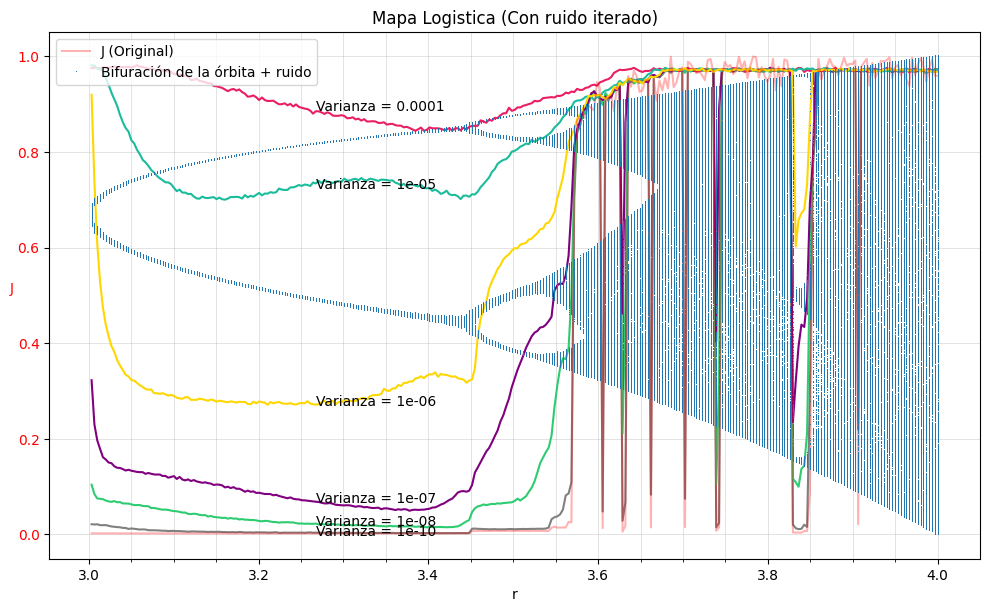

Correlación de Spearman: 0.8686061639074764


In [16]:
"""logistic ruido multiple
NO EDITAR HASTA CORRER LOS PROMEDIOS
"""


def logistic_map(r, x):
    return r * x * (1 - x)

def plot_orbit_diagram(num_partitions,discreto,interpolacion, size,graficar, r_min = 3.0, r_max = 4.0, num_points_per_r=300,
 num_iterations_discard=3000, num_iterations_display=2000):
    if discreto == "no" and interpolacion == "si": 
        print("Haz seleccionado interpolación a los datos continuos, eso no tiene caso")
        return 1,2

    if interpolacion == "si":
        print("Interpolación")

    ruidos = [1e-10,1e-8,1e-7,1e-4,1e-5,1e-6]
    colores = ['gray','#2ECC71','purple','#E91E63','#1ABC9C', '#FFD700']
    J_por_ruido = []
    for ruido in ruidos:   
        Jss = []
        vss = []
        for _ in range(100): 

            r_values = []
            orbit_values = []

            for r in np.linspace(r_min, r_max, num_points_per_r):
                
                x = 0.6
                if r == 3.0:
                    continue
                for _ in range(num_iterations_discard): # Converger
                    x = np.clip(x, 0.0, 1.0)
                    x = logistic_map(r, x) + generar_uniforme_centrada(1, ruido)[0]
                
                for _ in range(num_iterations_display):
                    x = np.clip(x, 0.0, 1.0)
                    x = logistic_map(r, x) + generar_uniforme_centrada(1, ruido)[0]
                    r_values.append(r)
                    orbit_values.append(x)
                
            #A partir de aqui, orbita continua de logistica completada
            if discreto == "si":
                print('Dinámica simbólica')
                # orbit_values = discretizar(orbit_values, num_partitions )

            a = 0
            b = 0
            J_values=[]
            J_index=[]
            lyapunov_values = []
            varianzas = []
            
            r_values_interp = []
            orbit_values_interp = np.array([])
            random_array = generar_uniforme_centrada(num_iterations_display,ruido)
            ti, to = True, True
            for i in range(0, len(r_values) - 1):
                if r_values[i] != r_values[i+1]:
                    r_single_orbit = orbit_values[a:i+1]
                    a = i+1
                    
                    if interpolacion == 'si':
                        x = np.arange(len(r_single_orbit))
                        # x_new, data_interp = interpolador(r_single_orbit, 'lineal', 15)
                        # data_interp = interpolador_estocastico(data_interp, 3)
                        data_interp = r_single_orbit
                        random_array = generar_uniforme_centrada(num_iterations_display,ruido)
                        data_interp = data_interp + random_array
                        r_values_interp = r_values_interp + [r_values[i]]*len(data_interp)
                        orbit_values_interp = np.concatenate((orbit_values_interp, data_interp))

                        r_single_orbit = data_interp

                    var = var_per_state(r_single_orbit, periodos_logistic[b])
                    if var == "Caos":
                        varianzas.append(np.nan)
                    else:
                        varianzas.append( np.sum(np.array(var))/periodos_logistic[b] )
                    # lyapunov = lyapunov_exponent_from_orbit(r_single_orbit, r_values[i])
                    # lyapunov_values.append(lyapunov)
                    J, angulos = J_univariante(r_single_orbit, 1, False)
                    # if r_values[i] > 2.8 and ti == True:
                    #     plt.plot(np.angle(np.fft.rfft(r_single_orbit)), ',')
                    #     plt.show()
                    #     plt.plot(r_single_orbit[:200], ',')
                    #     plt.show()
                    #     ti = False
                    #     plt.show()
                    # if J < 0.4 and to == True:
                    #     plt.plot(np.angle(np.fft.rfft(r_single_orbit)), ',')
                    #     plt.show()
                    #     print(r_values[i])
                    #     plt.plot(r_single_orbit, ',')
                    #     plt.show()
                    #     graficar_angulos_en_circulo(angulos)
                    #     plt.show()
                    #     to = False
                    J_values.append(J)
                    J_index.append(r_values[i])

                    b += 1
            
            #ultimo valor de r
            # lyapunov = lyapunov_exponent_from_orbit(orbit_values[a:], r_values[len(r_values) - 1])  
            # lyapunov_values.append(lyapunov)
            if interpolacion == 'si':
                x = np.arange(len(orbit_values[a:]))
                # x_new, data_interp = interpolador(orbit_values[a:], 'lineal', 15)
                # data_interp = interpolador_estocastico(data_interp, 3)
                data_interp = orbit_values[a:]
                random_array= generar_uniforme_centrada(num_iterations_display,ruido)
                data_interp = data_interp + random_array
                r_values_interp = r_values_interp + [r_values[i]]*len(data_interp)
                orbit_values_interp = np.concatenate((orbit_values_interp, data_interp))
                r_single_orbit = data_interp

            J = J_univariante(r_single_orbit, 1, False)[0]
            J_values.append(J)
            varianzas.append(np.nan)
            J_index.append(r_values[len(r_values) - 1])
            Jss.append(J_values)
            vss.append(varianzas)
        np.save('logistic_map/ruidos_promedios_iterado/varianza_por_ruido_'+ str(ruido) + '.npy', vss)
        np.save('logistic_map/ruidos_promedios_iterado/J_por_ruido_'+ str(ruido) + '.npy', Jss)
        J_por_ruido.append(np.mean(Jss,axis=0))
        print(ruido)

    #A partir de aqui, lyapunob y J fueron calculados

    J_continuo = np.load('logistic_map/j_logistic_continuo.npy')
    
    if graficar == True:
        fig, ax1 = plt.subplots(figsize=(10,6))
        
        if discreto == "no":
            color = "red"
        elif discreto == "si":
            color = "gray"
        for i,ruido in enumerate(ruidos):
            ax1.plot(J_index, J_por_ruido[i], color=colores[i] , alpha = 1)
            ax1.annotate(f'Varianza = {ruido}', xy=(J_index[len(J_index)//4], J_por_ruido[i][len(J_index)//4]), xytext=(10, J_por_ruido[i][-1]),
                         textcoords='offset points', ha='left', va='center')

        if discreto == "si":
            ax1.plot(J_index, J_continuo, 'red',label='J (Original)', alpha = 0.3)
            if interpolacion == "si":
                ax1.plot(r_values_interp, orbit_values_interp, ',', label=f'Bifuración de la órbita (+ ruido)', alpha=0.5)
            else: 
                ax1.plot(r_values, orbit_values, ',', label='Bifuración de la órbita + ruido', alpha=1)
        if discreto == "no":
            ax1.plot(r_values, orbit_values, ',', label='Bifurcación de la órbita', alpha=1)
        ax1.set_xlabel('r')
        ax1.set_ylabel('J', color='r', rotation = 360)
        ax1.tick_params(axis='y', labelcolor='r')
        # ax1.set_ylim(0,1)
        ax1.legend(loc = 'upper left')
        

        if discreto == "no":
            ax2 = ax1.twinx()
            ax2.axhline(y=0, color='black', linestyle='--', alpha =0.55)
            ax2.plot(J_index, lyapunov_values, 'black', label = 'λ')
            ax2.set_ylabel('λ', color='black', rotation = 360)
            ax2.tick_params(axis='y', labelcolor='black')
            ax2.legend(loc='center right',framealpha=0.5)
        
        fig.tight_layout()  
        major_ticks_x = np.linspace(3, 4, 6)  # 0.0, 0.2, ..., 1.0
        minor_ticks_x = np.linspace(3, 4, 21)  # Ticks secundarios

        major_ticks_y = np.linspace(0, 1, 6)  # -1, -0.5, 0, 0.5, 1.0
        minor_ticks_y = np.linspace(0, 1, 6)  # Ticks secundarios

        # Configurar los ticks del eje X
        plt.xticks(major_ticks_x)  # Solo etiquetar los ticks principales
        plt.gca().set_xticks(minor_ticks_x, minor=True)  # Agregar ticks menores sin etiquetas

        # Configurar los ticks del eje Y
        plt.yticks(major_ticks_y)  # Solo etiquetar los ticks principales
        plt.gca().set_yticks(minor_ticks_y, minor=True)  # Agregar ticks menores sin etiquetas

        # Activar la cuadrícula
        plt.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.5)  # Para ticks principales
        plt.grid(which='minor', linestyle='-', linewidth=0.5, alpha=0.5)  # Para ticks secundarios

        # plt.title(f'Logistic Map (Discret ={discreto}, interp= {interpolacion})')
        # plt.title(f'Mapa Logístico con discretización en el eje y ({num_partitions} Particiones)')
        plt.title(f'Mapa Logistica (Con ruido iterado)')
        plt.show()

    
    if interpolacion == 'no':
        return J_index, J_values, r_values, orbit_values, lyapunov_values
    else:
        return J_index, J_values, r_values_interp, orbit_values_interp, lyapunov_values 


with open('logistic_map/lyapunov_continuo.txt', 'r') as f:
        lyapunov_continuo = [float(line.strip()) for line in f]

J_continuo = np.load('logistic_map/j_logistic_continuo.npy')

J_index, J_values, r_values, orbit_values, lyapunov_values = plot_orbit_diagram(15,"si", "no", 20 ,True)
# J_index, J_values, r_values, orbit_values, lyapunov_values_continuo = plot_orbit_diagram(50,"no", "no", 20 ,True)


# Calcular correlación de Spearman
correlacion, p_valor = spearmanr(J_values, J_continuo)

print(f'Correlación de Spearman: {correlacion}')

Text(0.5, 1.0, 'Simulación de periodo-2 con incremento de separación d')

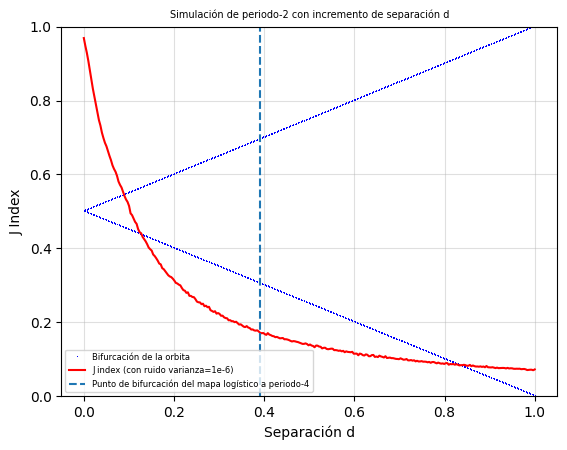

In [606]:
Jss= np.load('logistic_map\J_periodo2_simulado_100.npy')
# Jss=[]
# print(np.shape(Jss))
Js=[]
x1 = 0.5
d = 0.07
for d in np.linspace(0.0001,0.5,300):
    random = generar_uniforme_centrada(2000, 1e-6)
    array = np.array([x1-d,x1+d]*1000) + random
    x_index = [d*2]*len(array)
    # Js.append([J_univariante(array,1,False)[0]])
    plt.plot(x_index,array,',',color='blue')

plt.plot(x_index,array,',',color='blue',label='Bifurcación de la orbita')
plt.plot(np.linspace(0.0001,0.5,300)*2,np.mean(Jss,axis=0),color='red',label='J index (con ruido varianza=1e-6)')
plt.axvline(x = 0.39,linestyle='--', label = 'Punto de bifurcación del mapa logístico a periodo-4')
plt.xlabel('Separación d')
plt.ylabel('J Index')
plt.grid(alpha=0.4)
plt.ylim(0,1.0)
plt.legend(fontsize=6)
plt.title('Simulación de periodo-2 con incremento de separación d',fontsize=7)

In [17]:
"""NO EDITAR HASTA CORRER PROMEDIOS"""


# Jss= np.load('logistic_map/periodos_simulados/J_periodo4_simulado_1e-6.npy')
x1 = 0.44
x2 = 0.85
d_1 = 0.2431*np.sqrt(np.linspace(0,15.5,550))
d_2 = 0.1013*np.sqrt(np.linspace(0,15.5,550))
ruidos = [1e-10,1e-8,1e-7,1e-4,1e-5,1e-6]
colores = ['gray','#2ECC71','purple','#E91E63','#1ABC9C', '#FFD700']
for ruido in ruidos:
    J_por_ensamble = np.zeros((100,550))
    for j in range(100):
        Js=[]
        Js_ruido=[]
        for i,(d1,d2) in enumerate(zip(d_1,d_2)):
            array = [x2-d2/2,x1+d1/2,x2+d2/2,x1-d1/2]*500
            random = generar_uniforme_centrada(2000, ruido)
            array_ruido = array + random
            # x_index = [i]*len(array)
            # if d1 > 0.12:
            #     print(i)
            #     print('d1',d1)
            #     print('d2',d2)
            #     print((x2-d2/2)-(x1+d1/2))
            #     print([x2-d2/2,x1+d1/2,x2+d2/2,x1-d1/2])
            # Js.append(J_univariante(array,1,False)[0])
            # Js_ruido.append(J_univariante(array_ruido,1,False)[0])
            J_por_ensamble[j,i] = J_univariante(array_ruido,1,False)[0]
            # plt.plot(x_index,array_ruido,',',color='blue')
    np.save('logistic_map/periodos_simulados/J_periodo4_simulado_'+ str(ruido) + '.npy', J_por_ensamble)
    print(ruido)
# plt.plot(Js_ruido,label=f'J (ruido varianza = {ruido})',color='red')
# # for i,ruido in enumerate(ruidos):
# #     plt.plot(J_por_ruido[i], color=colores[i] , alpha = 1)
# #     plt.annotate(f'Varianza = {ruido}', xy=(75, J_por_ruido[i][75]), xytext=(10, J_por_ruido[i][-1]),
# #                     textcoords='offset points', ha='left', va='center')
# plt.plot(x_index,array,',',color='blue',label='Bifurcación de la orbita')
# # plt.plot(np.mean(Jss,axis=0),label='J (ruido varianza = 1e-6)',color='red')
# plt.plot(Js,label='J (sin ruido)',color='orange')
# plt.axvline(x = 9,linestyle='--', label = 'Bifurcación del mapa logístico en periodo-4 a un periodo-8')
# plt.xlabel('Separación d')
# plt.ylabel('J Index / Xn valores')
# plt.xticks(ticks=np.linspace(0,549,7), labels=np.round(0.2431*np.sqrt(np.linspace(0,15.5,7)), 2))
# plt.ylim(0,1.1)
# # plt.xlim(0,150)
# plt.legend(fontsize=7,loc='upper left')
# plt.title('Simulación de periodo-4 con incremento de separación d',fontsize=7)
# plt.show()
# faf = [0.8266028894540194, 0.5018966172993279, 0.8754054641352256, 0.3819299737785766]*500
# print(J_univariante(faf+random,1,False)[0])


1e-10
1e-08
1e-07
0.0001
1e-05
1e-06


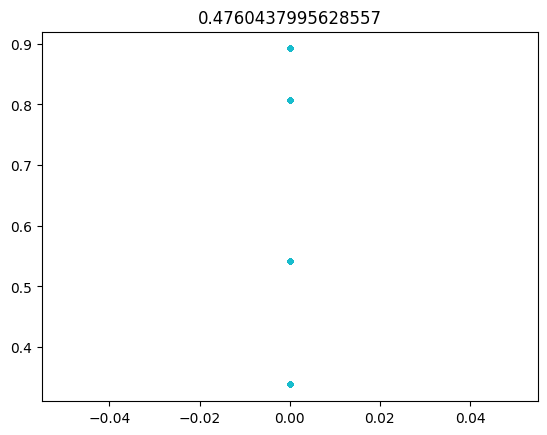

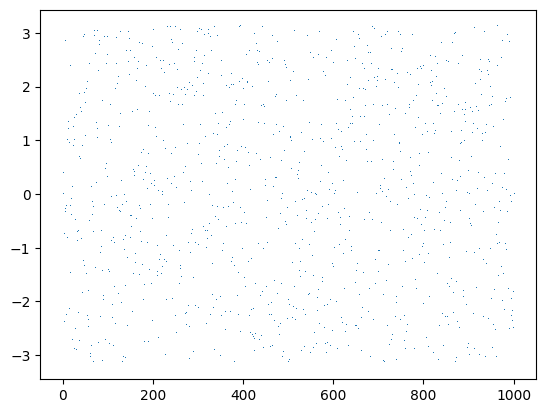

In [670]:
ge=[]
for _ in range(100):
    d1 = 0.2431*np.sqrt(0.7)
    d2 = 0.1013*np.sqrt(0.7)
    array = [x2-d2/2,x1+d1/2,x2+d2/2,x1-d1/2]*500
    plt.plot([0]*2000, array,'.')
    # print(array[:5])
    j=J_univariante(array+generar_uniforme_centrada(len(array),1e-6),1,False)[0]
    ge.append(j)
plt.title(np.mean(ge))
plt.show()
plt.plot(np.angle(np.fft.rfft(array+generar_uniforme_centrada(len(array),1e-6))),',')

# Ruido sumado
$X_{t+1} = X_{t}r (1 - X_{t}) $ \
$X'_{t+1} = X_{t+1}  + \eta_{t} $ \
$X'_{t+2} = X_{t+2} + \eta_{t+1}$ \
$X'_{t+3} = X_{t+3} + \eta_{t+2}$

# Ruido iterado
$X'_{t+1} = X_{t+1} + \eta_{t} $ \
$X'_{t+2} = X'_{t+1} + \eta_{t+1} $ \
$X'_{t+3} = X'_{t+2} + \eta_{t+2} $ 

Correlación de Spearman: 0.7703832264802941

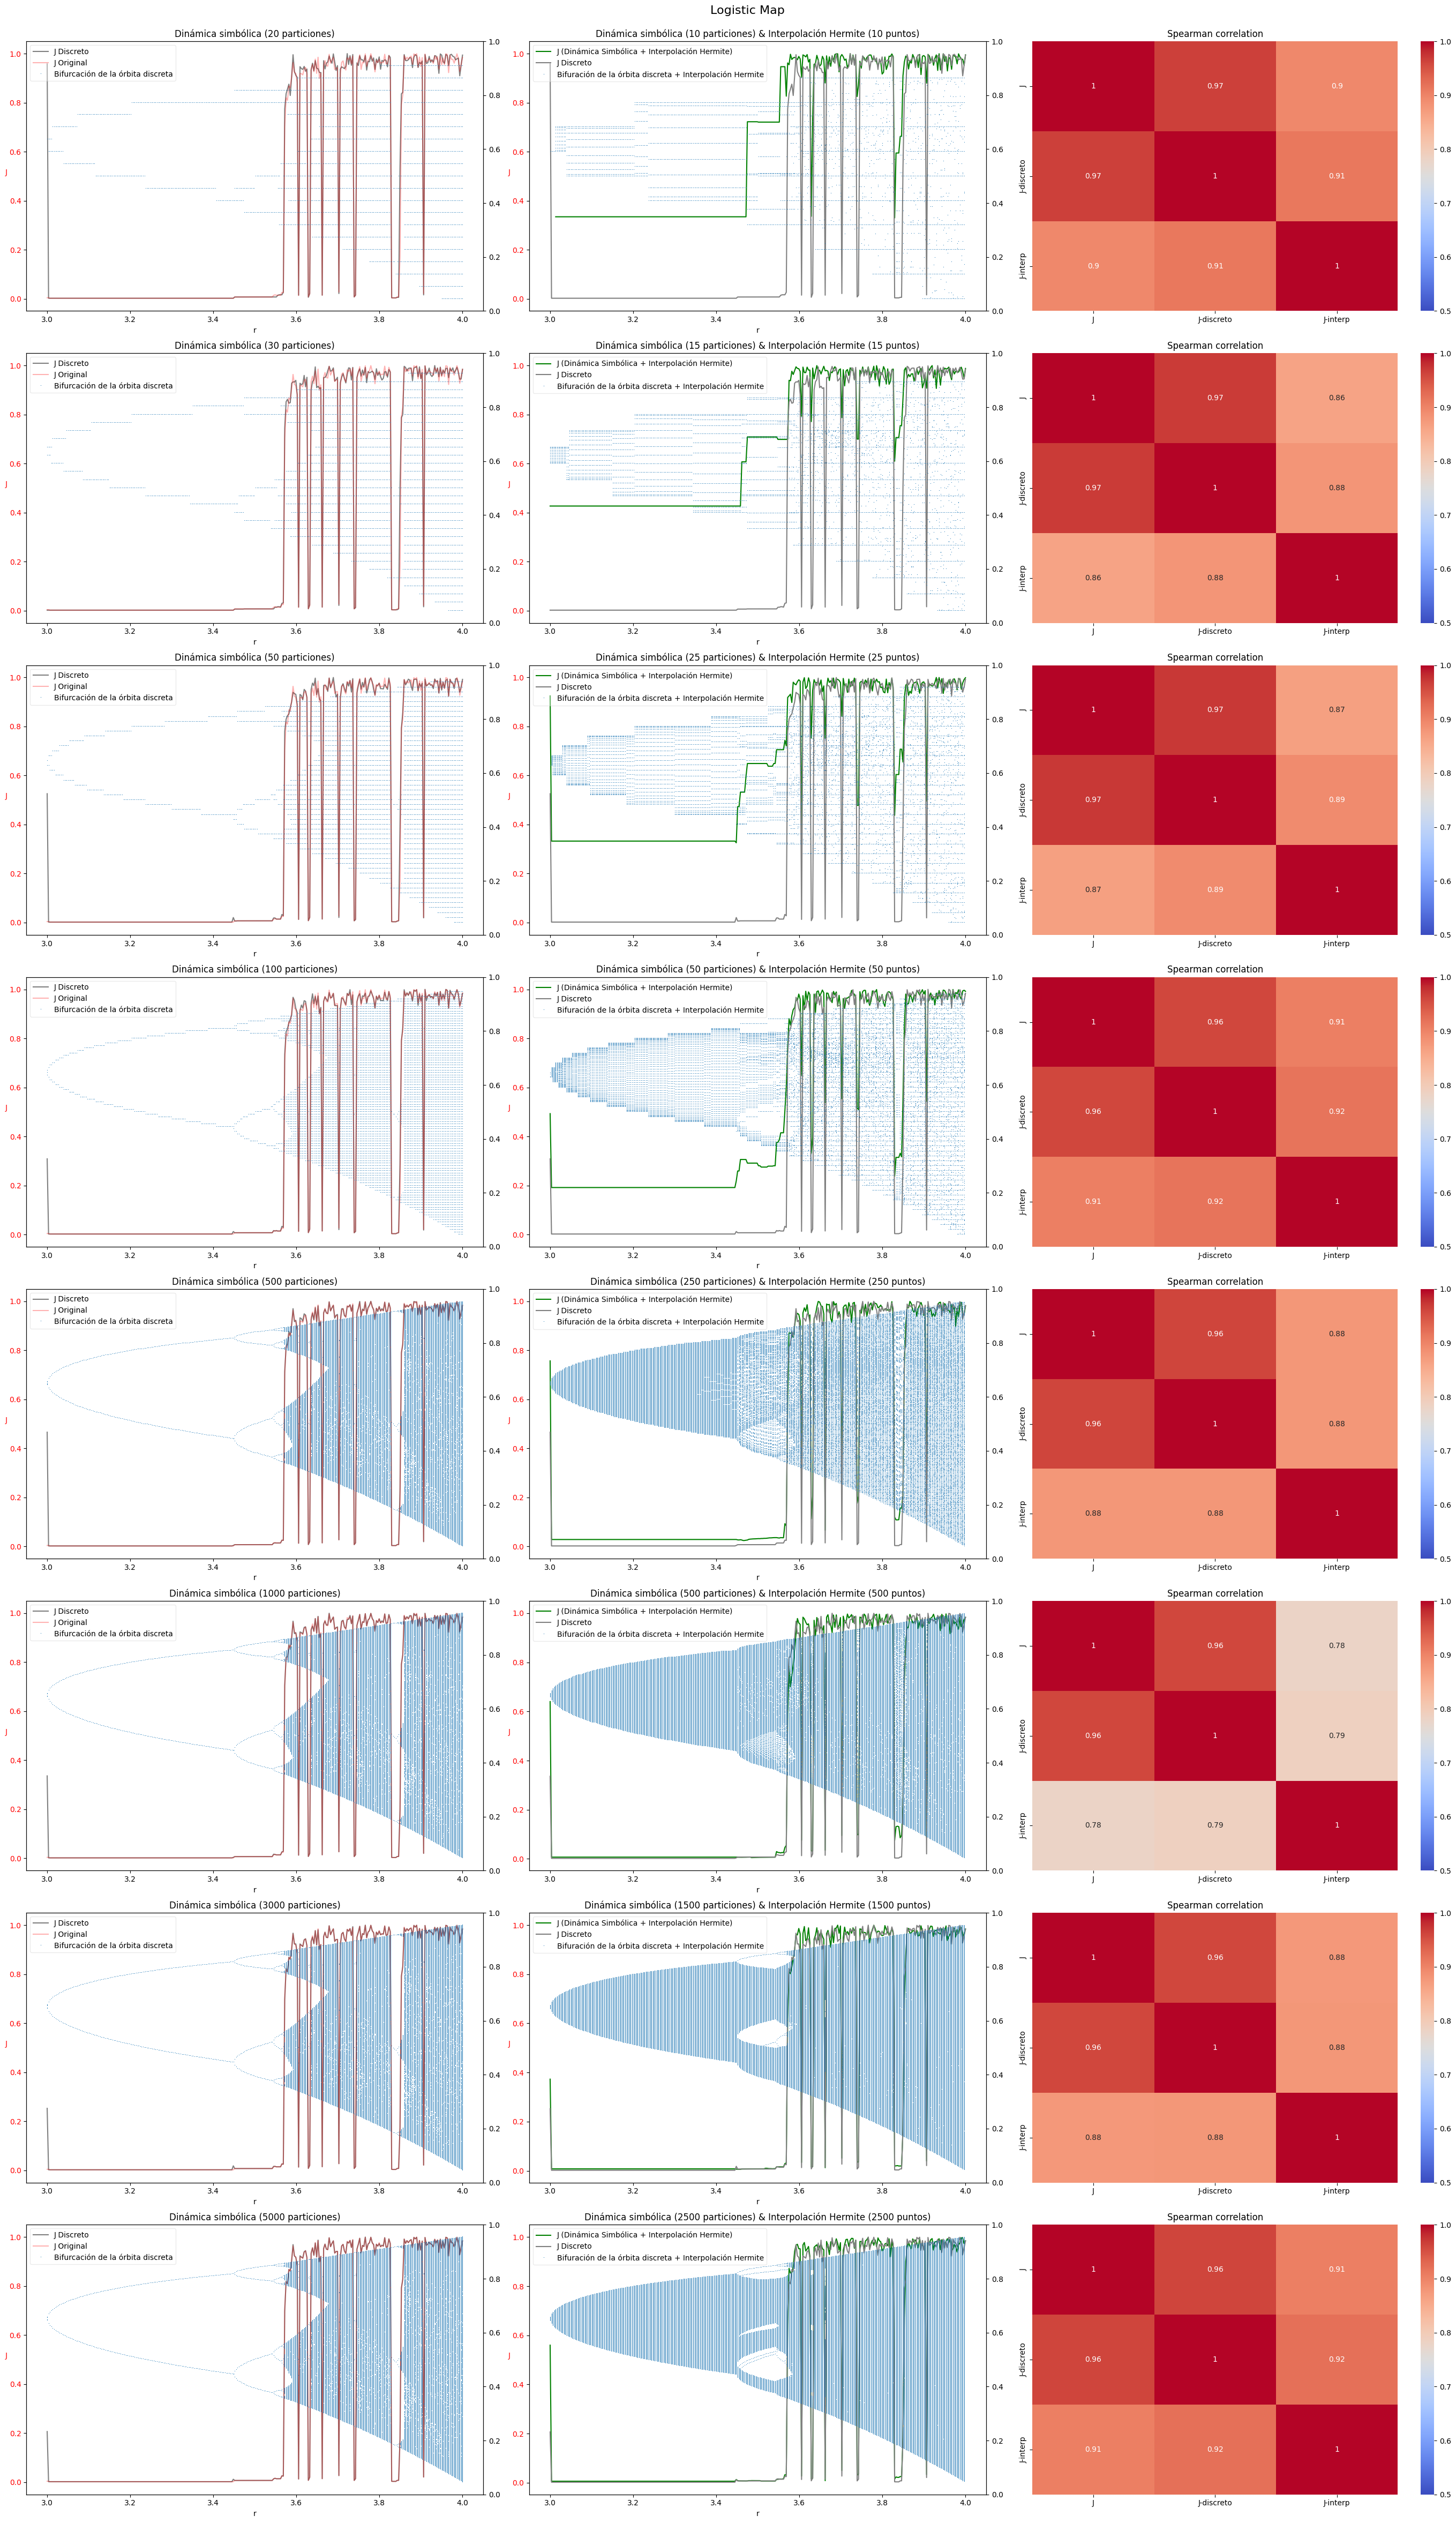

In [37]:
carpeta = 'logistic_map_herm'
guardar = False

corr_J_discret_list, corr_J_interp_herm, corr_lyapunov_discret_list, corr_lyapunov_interp_herm = [],[],[],[]
# corr_J_discret_list, corr_J_interp_lineal, corr_lyapunov_discret_list, corr_lyapunov_interp_lineal = [],[],[],[]

with open('logistic_map/lyapunov_continuo.txt', 'r') as f:
        lyapunov_continuo = [float(line.strip()) for line in f]

with open('logistic_map/j_logistic_continuo.txt', 'r') as f:
        J_continuo = [float(line.strip()) for line in f]

with open('logistic_map/j_index.txt', 'r') as f:
        J_index = [float(line.strip()) for line in f]

# Primera fila
splits = [20, 30, 50,100, 500, 1000, 3000, 5000]
# splits = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19, 20, 30, 50,100, 500, 1000,1500,2000,2500, 3000,3500, 4000,4500, 5000]

# splits = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
# splits = [1500, 2500, 3500,4500]
fig, axs = plt.subplots(len(splits), 3, figsize=(28, 48))
for i,split in enumerate(splits):
    size = split//2

    # [0,0]
    if guardar == False:
        data = pd.read_csv(carpeta + '/df_' + str(split) + '.csv')
        data_discreto = pd.read_csv(carpeta + '/df_discreto_' + str(split) + '.csv')
        data_interp = pd.read_csv(carpeta + '/df_interp_' + str(split) + '.csv')
        J_values = data['J-discreto']
        r_values = data_discreto['r_values']
        orbit_values = data_discreto['orbit_values']
        lyapunov_values = data['λ-discreto']
        J_values_interp = data['J-interp']
        r_values_interp = data_interp['r_values_interp']
        orbit_values_interp = data_interp['orbit_values_interp']
        lyapunov_values_interp = data['λ-interp']
        data2 = data.drop(['λ-interp','λ-discreto','λ'], axis=1)
    
    if guardar == True:    
        J_index, J_values, r_values, orbit_values, lyapunov_values = plot_orbit_diagram(split,"si", 'no', size, False)

    axs[i, 0].plot(J_index, J_values, 'gray' , label='J Discreto', alpha = 1)
    axs[i, 0].plot(J_index, J_continuo, 'red', alpha = 0.3, label = 'J Original')
    axs[i, 0].plot(r_values, orbit_values, ',', label='Bifurcación de la órbita discreta', alpha=1)
    axs[i, 0].set_title(f'Dinámica simbólica ({split} particiones)')
    axs[i, 0].set_xlabel('r')
    axs[i, 0].set_ylabel('J', color='r', rotation = 360)
    axs[i, 0].tick_params(axis='y', labelcolor='r')
    axs[i, 0].legend(loc = 'upper left', framealpha = 0.4)

    ax2 = axs[i, 0].twinx()

    # ax2.axhline(y=0, color='black', linestyle='--', alpha =0.55)
    # ax2.plot(J_index, lyapunov_values, 'black', label = 'λ')
    # ax2.set_ylabel('λ', color='black', rotation = 360)
    # ax2.tick_params(axis='y', labelcolor='black')
    # ax2.legend(loc='center right',framealpha=0.5)



    # [0, 1]
    if guardar == True:
        J_index, J_values_interp, r_values_interp, orbit_values_interp, lyapunov_values_interp = plot_orbit_diagram(split//2,"si", 'si', size, False)

    axs[i, 1].plot(J_index, J_values_interp, 'green' , label='J (Dinámica Simbólica + Interpolación Hermite)', alpha = 1)
    axs[i, 1].plot(J_index, J_values, 'gray' , label='J Discreto', alpha = 1)
    axs[i, 1].plot(r_values_interp, orbit_values_interp, ',', label='Bifuración de la órbita discreta + Interpolación Hermite', alpha=1)
    axs[i, 1].set_xlabel('r')
    axs[i, 1].set_ylabel('J', color='r', rotation = 360)
    axs[i, 1].tick_params(axis='y', labelcolor='r')
    axs[i, 1].set_title(f'Dinámica simbólica ({split//2} particiones) & Interpolación Hermite ({size} puntos)')
    axs[i, 1].legend(loc = 'upper left',framealpha = 0.4)
    ax3 = axs[i, 1].twinx()

    # ax3.axhline(y=0, color='black', linestyle='--', alpha =0.55)
    # ax3.plot(J_index, lyapunov_values_interp, 'black', label = 'λ')
    # ax3.set_ylabel('λ', color='black', rotation = 360)
    # ax3.tick_params(axis='y', labelcolor='black')
    # ax3.legend(loc='center right',framealpha=0.5)

    # [0, 2]
    """Compute"""
    ########################
    if guardar == True:
        data = pd.DataFrame({
                'J': J_continuo,
                'J-discreto': J_values,
                'J-interp': J_values_interp,
                'λ': lyapunov_continuo,
                'λ-discreto': lyapunov_values,
                'λ-interp': lyapunov_values_interp,
        })
        data.to_csv(carpeta + '/df_' + str(split) + '.csv', index=False)

        data_interp = pd.DataFrame({
                'r_values_interp': r_values_interp,
                'orbit_values_interp': orbit_values_interp,
        })

        data_discreto = pd.DataFrame({
                'r_values': r_values,
                'orbit_values': orbit_values,
        })

        # with open('J_index.txt', "w") as f:
        #         for item in J_index: # a menos que cambie tamaño de iteraciones de función, no guardar J_index
        #         f.write(f"{item}\n")
        
        data_discreto.to_csv(carpeta + '/df_discreto_' + str(split) + '.csv', index=False)
        data_interp.to_csv(carpeta + '/df_interp_' + str(split) + '.csv', index=False)
    ########################

    corr_spearman = data2.corr(method='spearman')
    # corr_J_discret_list.append(corr_spearman.loc['J','J-discreto'])
    # corr_J_interp_lineal.append(corr_spearman.loc['J','J-interp'])
    # corr_lyapunov_discret_list.append(corr_spearman.loc['λ','λ_discreto'])
    # corr_lyapunov_interp_lineal.append(corr_spearman.loc['λ','λ_interp'])

    # mask = np.ones_like(corr_spearman, dtype=bool)
    # for k in [0, 1, 2]:
    #     for l in [0, 1, 2]:
    #         mask[k,l] = False
    #     for l in [3, 4, 5]:
    #         mask[k+3, l] = False 
    # corr_spearman = corr_spearman.where(~mask)
    sns.heatmap(corr_spearman, ax=axs[i, 2], annot=True, cmap='coolwarm', vmin=0.5, vmax=1.0)
    axs[i, 2].set_title('Spearman correlation')

# Ajustar el layout para que no haya superposición de títulos y etiquetas
plt.tight_layout()

# Mostrar el plot
plt.suptitle('Logistic Map', fontsize=16)
plt.subplots_adjust(top=0.966) 
plt.show()

# plt.plot(splits, )


In [13]:
"""Grafica  de corr vs M para lyapunov y J discretos
Grafica de corr vs M para lyapunov y J interpolados lineal y hermite 
Xn vs r 50 particiones J_original, J_discreta, lyapunov_discreto
Xn vs r 1500 particiones J_original, J_discreta, lypunov_discreto"""

'Grafica  '

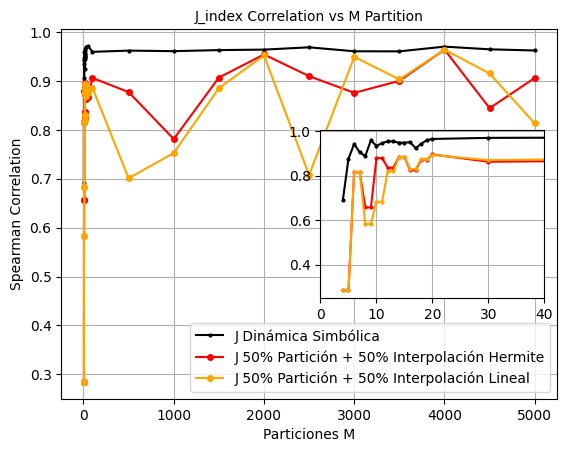

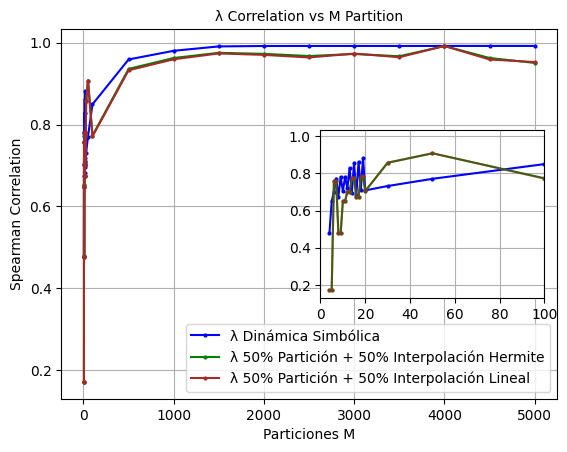

In [146]:
x = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19, 20, 30, 50,100, 500, 1000,1500,2000,2500, 3000,3500, 4000,4500, 5000]

# Crear la gráfica principal
fig, ax = plt.subplots()
ax.plot(x,corr_J_discret_list, label = 'J Dinámica Simbólica',markersize = 4, color = 'black', marker='.', linestyle='-')
ax.plot(x, corr_J_interp_herm, markersize = 4, label = 'J 50% Partición + 50% Interpolación Hermite', color = 'red', marker='o', linestyle='-')
ax.plot(x, corr_J_interp_lineal,markersize = 4, label = 'J 50% Partición + 50% Interpolación Lineal',color = 'orange', marker='o', linestyle='-')
# Crear la gráfica de zoom como un inset
ax_inset = fig.add_axes([0.53, 0.32, 0.35, 0.35])  # [left, bottom, width, height] en coordenadas normalizadas
ax_inset.plot(x,corr_J_discret_list, color='black',marker='.', linestyle='-', markersize = 4)
ax_inset.plot(x,corr_J_interp_herm, color='red',marker='.', linestyle='-', markersize = 4)
ax_inset.grid()
ax_inset.plot(x,corr_J_interp_lineal, color='orange', marker='.', linestyle='-', markersize = 4)
ax_inset.set_xlim(0, 40)
ax.set_xlabel('Particiones M')
ax.set_ylabel('Spearman Correlation')
ax.grid()
ax.set_title('J_index Correlation vs M Partition', fontsize=10)
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(x,corr_lyapunov_discret_list, label = 'λ Dinámica Simbólica',color = 'blue',markersize = 4, marker='.', linestyle='-')
ax.plot(x, corr_lyapunov_interp_herm, label = 'λ 50% Partición + 50% Interpolación Hermite',color = 'green',markersize = 4, marker='.', linestyle='-')
ax.plot(x, corr_lyapunov_interp_lineal, label = 'λ 50% Partición + 50% Interpolación Lineal',color = 'brown',markersize = 4, marker='.', linestyle='-')
# Crear la gráfica de zoom como un inset
ax_inset = fig.add_axes([0.53, 0.32, 0.35, 0.35])  # [left, bottom, width, height] en coordenadas normalizadas
ax_inset.plot(x,corr_lyapunov_discret_list, color='blue',marker='.', linestyle='-', markersize = 4)
ax_inset.plot(x,corr_lyapunov_interp_herm, color='green',marker='.', linestyle='-', markersize = 4)
ax_inset.grid()
ax_inset.plot(x,corr_lyapunov_interp_lineal, color='brown',alpha = 0.5, marker='.', linestyle='-', markersize = 4)
ax_inset.set_xlim(0, 100)
ax.set_xlabel('Particiones M')
ax.set_ylabel('Spearman Correlation')
ax.grid()
ax.set_title('λ Correlation vs M Partition',fontsize=10)
ax.legend()
plt.show()